In [56]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt 
import import_ipynb
from one_iv_computation import get_spot_and_risk_free_rate
from four_market_maker import MarketMaker, Option, get_mm_table 
IV_surface_calls = pd.read_pickle('IV_surface_calls.pkl')
IV_surface_puts = pd.read_pickle('IV_surface_puts.pkl')

In [57]:
spot, rfr = get_spot_and_risk_free_rate()

call_surface_df = get_mm_table(IV_surface_calls, spot)
put_surface_df  = get_mm_table(IV_surface_puts,  spot)

mm = MarketMaker(call_surface_df, put_surface_df, spot, rfr)

In [58]:
call_surface_df["type"] = "call" 
put_surface_df["type"] = "put" 

nodes = pd.concat([call_surface_df, put_surface_df], ignore_index=True)
#print(nodes)

nodes["moneyness"] = nodes["strike"] / spot 
nodes["T"] = nodes["dte"] / 365.0 

In [59]:
def risk(g, w_delta = 1e-4, w_tau = 1e-4, w_gamma = 1e-6, w_theta = 1e-8):
    # sum of squares of greeks (weighted by "importance" (I chose these to favor delta and tau)
    # I call this "risk" to evaluate the riskiness of a trade 
    sum = w_delta*g["delta"]**2 + w_tau*g["tau"]**2 + w_gamma*g["gamma"]**2 + w_theta*g["theta"]**2
    return sum 



In [60]:
rng = np.random.default_rng(0)

def step(mm, nodes, quantity = 1):
    row = nodes.iloc[rng.integers(0,len(nodes))]
    opt = Option(row["strike"], row["dte"], row["type"])
    side = "buy" if rng.random() < 0.5 else "sell" 

    greeks_init = mm.port_greeks()
    risk_init = risk(greeks_init)

    mm.trade(opt, side, quantity)
    greeks_post = mm.port_greeks()
    risk_post = risk(greeks_post)

    d_risk = risk_post - risk_init 
    accept = (d_risk <= 0) or (rng.random() < np.exp(-d_risk))
    
    if not accept:
        if side == "buy":
            mm.trade(opt, "sell", quantity)
        else:
            mm.trade(opt, "buy", quantity) 
        return None 
    
    step_summary = {"m": row["moneyness"], "T": row["T"], "type": row["type"], "risk added/lost": d_risk}
    return step_summary 


In [ ]:
path = []

N = 25000

for i in range(N):
    new_step = step(mm, nodes, 1)
    if new_step is not None:
        path.append(new_step)

#print(path[0])
path = pd.DataFrame(path)

moneyness_bins = np.linspace(0.85, 1.15, 60)
time_bins = np.linspace(path["T"].min(), path["T"].max(), 60)

H, _ , _ = np.histogram2d(path["m"], path["T"], bins = [moneyness_bins, time_bins], density = True)

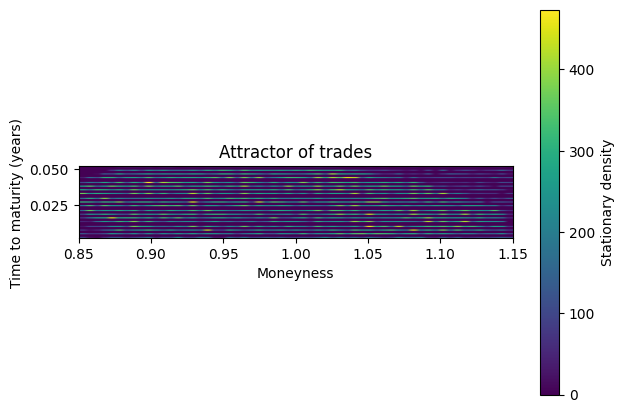

In [62]:
plt.figure(figsize=(7,5))
plt.imshow(H.T, extent=[moneyness_bins[0], moneyness_bins[-1], time_bins[0], time_bins[-1]])
plt.colorbar(label = "Stationary density")
plt.xlabel("Moneyness")
plt.ylabel("Time to maturity (years)")
plt.title("Attractor of trades")
plt.savefig("trading-attractor")
plt.show()

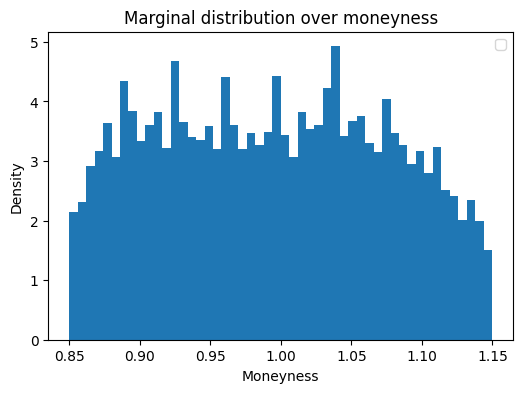

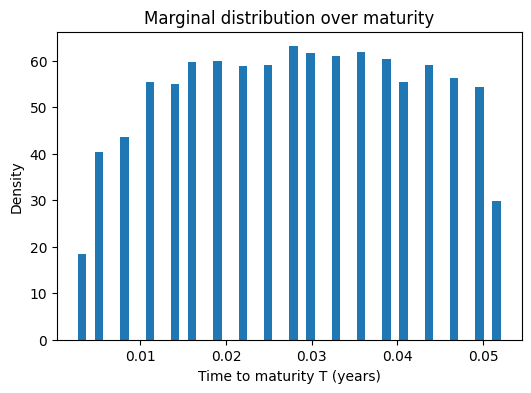

In [63]:
plt.figure(figsize=(6,4))
plt.hist(path["m"], bins=50, density=True)
plt.xlabel("Moneyness")
plt.ylabel("Density")
plt.title("Marginal distribution over moneyness")
plt.legend()
plt.savefig("dist-over-moneyness")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(path["T"], bins=50, density=True)
plt.xlabel("Time to maturity T (years)")
plt.ylabel("Density")
plt.title("Marginal distribution over maturity")
plt.savefig("dist-over-expiry")
plt.show()

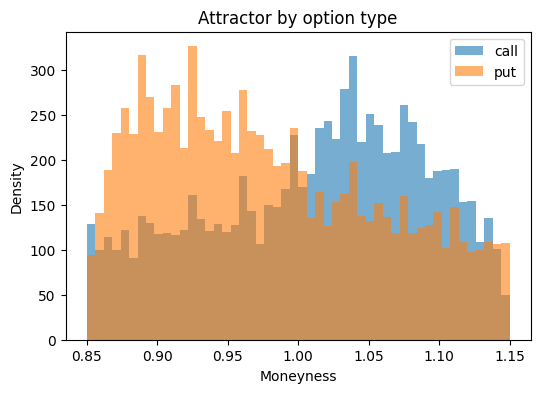

In [64]:
plt.figure(figsize=(6,4))
for opt_type in ["call", "put"]:
    subset = path[path["type"] == opt_type]
    plt.hist(subset["m"],bins=50,alpha=0.6,label=opt_type)

plt.xlabel("Moneyness")
plt.ylabel("Density")
plt.title("Attractor by option type")
plt.legend()
plt.savefig("attractor (by type)")
plt.show()